In [1]:
from astropy import units as u, constants as const
import tardis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import ndimage

from tardis.simulation import Simulation
from tardis.io.config_reader import Configuration
from tardis.io.atom_data import AtomData
from tardis.plasma.base import BasePlasma
from tardis.plasma.properties.base import DataFrameInput, ProcessingPlasmaProperty
from tardis.plasma.properties.property_collections import (
    basic_inputs,
    basic_properties,
    lte_excitation_properties,
    lte_ionization_properties,
    macro_atom_properties,
    dilute_lte_excitation_properties,
    nebular_ionization_properties,
    non_nlte_properties,
    nlte_properties,
    helium_nlte_properties,
    helium_numerical_nlte_properties,
    helium_lte_properties,
    detailed_j_blues_properties,
    detailed_j_blues_inputs,
    continuum_interaction_properties,
    continuum_interaction_inputs,
    adiabatic_cooling_properties,
    two_photon_properties,
)

from stardis.plasma import AlphaLine, HMinusDensity, TracingNus
from star_test import calc_tau_h_minus, calc_tau_nus, calc_weights

Iterations:          0/? [00:00<?, ?it/s]

Packets:             0/? [00:00<?, ?it/s]

In [2]:
sun_spec = pd.read_csv('data/solar_data/NewGuey2003.txt', skiprows=20, delim_whitespace=True, names=['wave', 'flux'])
sun_spec['wave'] *= 10
sun_spec['flux'] = u.Quantity(sun_spec['flux'].to_numpy(), "W/(m2 nm)").to("erg/(s cm2 AA)").value

(2000.0, 9000.0)

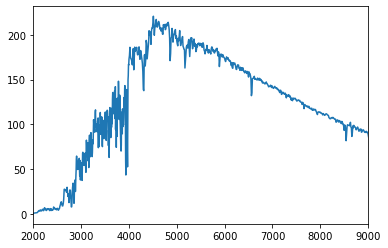

In [3]:
plt.plot(sun_spec.wave, sun_spec.flux)
plt.xlim(2000, 9000)

## Model & Atomic Data

In [4]:
def read_marcs(fname, atom_data):
    marcs_model1 = pd.read_csv(fname,skiprows=24, nrows=56, 
                               delim_whitespace=True, index_col='k')
    marcs_model2 = pd.read_csv(fname,skiprows=81, nrows=56, 
                               delim_whitespace=True, index_col='k')
    del marcs_model2['lgTauR']
    marcs_model = marcs_model1.join(marcs_model2)
    marcs_model.columns = [item.lower() for item in marcs_model.columns]
    marcs_model['lgtaur'] = 10**marcs_model['lgtaur']
    marcs_model['lgtau5'] = 10**marcs_model['lgtau5']
    
    marcs_model = marcs_model.rename(columns={'lgtaur':'tau_ref', 'lgtau5':'tau_500'})
    with open(fname) as fh:
        marcs_lines = fh.readlines()
    marcs_abundance_scale_str = ' '.join([item.strip() for item in marcs_lines[12:22]])
    marcs_abundances = pd.DataFrame(data=map(np.float64, marcs_abundance_scale_str.split()), columns=['abundance_scale'])
    marcs_abundances.replace({-99:np.nan}, inplace=True)
    marcs_abundances = marcs_abundances.set_index(np.arange(1, len(marcs_abundances)+1))
    marcs_abundances.index.name = 'atomic_number'
    marcs_abundances['mass_density'] = ((10**marcs_abundances['abundance_scale']) * 
                                        atom_data.atom_data.mass)
    marcs_abundances['mass_abundance'] = marcs_abundances['mass_density'] / marcs_abundances['mass_density'].sum()
    return marcs_model[::-1], marcs_abundances

# Converting model from finite difference to finite volume (cell boundaries to cells)
# Shape changes here because of averaging adjacent rows
def convert_marcs_finite_volume(marcs_model):
    marcs_model_fv = pd.DataFrame(data=0.5 * (marcs_model.iloc[:-1].values + marcs_model.iloc[1:].values), 
                                columns=marcs_model.columns)
    marcs_model_fv['r_inner'] = marcs_model['depth'].iloc[:-1].values
    marcs_model_fv['r_outer'] = marcs_model['depth'].iloc[1:].values
    marcs_model_fv['cell_length'] = -(marcs_model_fv['r_outer'].values - marcs_model_fv['r_inner'].values)
    return marcs_model_fv

In [5]:
adata = AtomData.from_hdf('kurucz_cd23_chianti_H_He.h5')
#adata.prepare_atom_data(marcs_abundances_all.index.tolist())
marcs_model, marcs_abundances_uniform = read_marcs('data/marcs/sun.mod', adata)
marcs_model

,tau_ref,tau_500,depth,t,pe,pg,prad,pturb,kappaross,density,mu,vconv,fconv/f,rhox
k,,,,,,,,,,,,,,
56,100.000000,58.979352,12340000.0,9934.3,8891.700000,218920.00,24.5560,0.0,78.748000,3.222400e-07,1.216,218200.0,0.97743,8.066432
55,63.095734,37.792011,10630000.0,9678.4,6792.000000,204310.00,22.1220,0.0,60.427000,3.110500e-07,1.225,226100.0,0.96002,7.525328
54,39.810717,24.372496,9171000.0,9424.6,5151.400000,192240.00,19.8900,0.0,45.965000,3.025700e-07,1.233,232200.0,0.94123,7.078444
53,25.118864,15.816122,7926000.0,9168.5,3857.700000,182180.00,17.8110,0.0,34.543000,2.964400e-07,1.240,237600.0,0.91188,6.705387
52,15.848932,10.318106,6851000.0,8903.8,2826.400000,173660.00,15.8380,0.0,25.489000,2.924300e-07,1.247,241200.0,0.86307,6.389028
51,10.000000,6.762387,5907000.0,8620.2,1994.300000,166280.00,13.8880,0.0,18.243000,2.904800e-07,1.252,242100.0,0.78270,6.113838
50,7.943282,5.482770,5478000.0,8462.6,1630.700000,162880.00,12.8690,0.0,15.097000,2.904200e-07,1.255,239900.0,0.71979,5.989352
49,6.309573,4.446313,5063000.0,8290.4,1299.800000,159590.00,11.8030,0.0,12.243000,2.910100e-07,1.257,233300.0,0.62604,5.868536
48,5.011872,3.604956,4651000.0,8097.7,999.240000,156320.00,10.6680,0.0,9.655300,2.923400e-07,1.259,220500.0,0.49909,5.748368


In [6]:
marcs_abundances_uniform['mass_abundance']

atomic_number
1     7.382733e-01
2     2.495226e-01
3     5.725908e-11
4     1.583425e-10
5     3.969481e-09
          ...     
88             NaN
89             NaN
90             NaN
91             NaN
92             NaN
Name: mass_abundance, Length: 92, dtype: float64

In [7]:
marcs_model_fv = convert_marcs_finite_volume(marcs_model)
marcs_model_fv

,tau_ref,tau_500,depth,t,pe,pg,prad,pturb,kappaross,density,mu,vconv,fconv/f,rhox,r_inner,r_outer,cell_length
0,81.547867,48.385682,11485000.0,9806.35,7841.850000,211615.000,23.33900,0.0,69.587500,3.166450e-07,1.2205,222150.00,0.968725,7.795880,12340000.0,10630000.0,1710000.0
1,51.453226,31.082253,9900500.0,9551.50,5971.700000,198275.000,21.00600,0.0,53.196000,3.068100e-07,1.2290,229150.00,0.950625,7.301886,10630000.0,9171000.0,1459000.0
2,32.464791,20.094309,8548500.0,9296.55,4504.550000,187210.000,18.85050,0.0,40.254000,2.995050e-07,1.2365,234900.00,0.926555,6.891915,9171000.0,7926000.0,1245000.0
3,20.483898,13.067114,7388500.0,9036.15,3342.050000,177920.000,16.82450,0.0,30.016000,2.944350e-07,1.2435,239400.00,0.887475,6.547207,7926000.0,6851000.0,1075000.0
4,12.924466,8.540247,6379000.0,8762.00,2410.350000,169970.000,14.86300,0.0,21.866000,2.914550e-07,1.2495,241650.00,0.822885,6.251433,6851000.0,5907000.0,944000.0
5,8.971641,6.122578,5692500.0,8541.40,1812.500000,164580.000,13.37850,0.0,16.670000,2.904500e-07,1.2535,241000.00,0.751245,6.051595,5907000.0,5478000.0,429000.0
6,7.126428,4.964541,5270500.0,8376.50,1465.250000,161235.000,12.33600,0.0,13.670000,2.907150e-07,1.2560,236600.00,0.672915,5.928944,5478000.0,5063000.0,415000.0
7,5.660723,4.025634,4857000.0,8194.05,1149.520000,157955.000,11.23550,0.0,10.949150,2.916750e-07,1.2580,226900.00,0.562565,5.808452,5063000.0,4651000.0,412000.0
8,4.496472,3.262536,4440000.0,7987.30,864.375000,154640.000,10.06380,0.0,8.488000,2.934600e-07,1.2600,209350.00,0.420700,5.686508,4651000.0,4229000.0,422000.0
9,3.571675,2.640025,4003500.0,7747.55,612.210000,151160.000,8.83360,0.0,6.291150,2.962100e-07,1.2620,180450.00,0.261050,5.557841,4229000.0,3778000.0,451000.0


In [8]:
marcs_abundances_all = pd.DataFrame(columns=marcs_model_fv.index.values, 
                    index=marcs_abundances_uniform.index)
for i in range(len(marcs_abundances_all.columns)):
    marcs_abundances_all[i] = marcs_abundances_uniform['mass_abundance']
#marcs_abundances_all = marcs_abundances_all.loc[30:1][::-1]

# pure hydrogen
marcs_abundances_all = marcs_abundances_all.iloc[[0]]
marcs_abundances_all.iloc[:] = 1.0

In [9]:
adata = AtomData.from_hdf('kurucz_cd23_chianti_H_He.h5')
adata.prepare_atom_data(marcs_abundances_all.index.tolist())

## Plasma

In [10]:
# Code that hasn't seen light of the day yet, might be useful in future

class InputNumberDensity(DataFrameInput):
    """
    Attributes
    ----------
    number_density : Pandas DataFrame, dtype float
                     Indexed by atomic number, columns corresponding to zones
    """

    outputs = ("number_density",)
    latex_name = ("N_{i}",)
    
class SelectedAtoms(ProcessingPlasmaProperty):
    """
    Attributes
    ----------
    selected_atoms : Pandas Int64Index, dtype int
                     Atomic numbers of elements required for particular simulation
    """

    outputs = ("selected_atoms",)

    def calculate(self, number_density):
        return number_density.index

def assemble_plasma(marcs_df):
    pass

In [11]:
#basic_properties.remove(tardis.plasma.properties.general.NumberDensity)
plasma_modules = []
plasma_modules += basic_inputs
plasma_modules += basic_properties
plasma_modules += lte_ionization_properties
plasma_modules += lte_excitation_properties
plasma_modules += non_nlte_properties

plasma_modules.append(tardis.plasma.properties.partition_function.LevelBoltzmannFactorNoNLTE)
plasma_modules.remove(tardis.plasma.properties.radiative_properties.TauSobolev)
plasma_modules.remove(tardis.plasma.properties.plasma_input.TimeExplosion)
plasma_modules.remove(tardis.plasma.properties.plasma_input.DilutionFactor)
plasma_modules.remove(tardis.plasma.properties.plasma_input.HeliumTreatment)
plasma_modules.remove(tardis.plasma.properties.plasma_input.ContinuumInteractionSpecies)
plasma_modules+= helium_lte_properties
plasma_modules.append(AlphaLine)
plasma_modules.append(HMinusDensity)
plasma_modules.append(TracingNus)
#plasma_modules.remove(tardis.plasma.properties.radiative_properties.StimulatedEmissionFactor)

#plasma_modules.remove(tardis.plasma.properties.general.SelectedAtoms)
#plasma_modules.remove(tardis.plasma.properties.plasma_input.Density)


In [12]:
tracing_wavelength = np.arange(2000, 10000, 1000) * u.Angstrom
tracing_nus = tracing_wavelength.to(u.Hz, u.spectral())

splasma = BasePlasma(
        plasma_properties=plasma_modules,
        t_rad=marcs_model_fv.t.values, abundance=marcs_abundances_all,
        atomic_data=adata, 
        density=marcs_model_fv.density.values,
        link_t_rad_t_electron=1.0,
        tracing_nus=tracing_nus 
        )

## RT Calculation

In [13]:
tau_h_minus = calc_tau_h_minus(
    h_neutral_density=splasma.ion_number_density.loc[(1, 0)].values,
    temperature=marcs_model_fv.t.values * u.K,
    electron_density=splasma.electron_densities.values,
    wbr_fpath="data/wishart_broad_reinhardt_cross_section.dat",
    tracing_wavelength=tracing_wavelength,
    cell_length=marcs_model_fv.cell_length.values,
)
tau_h_minus

array([[5.09089067e+00, 8.71908599e+00, 1.23973662e+01, 1.57417470e+01,
        1.84829544e+01, 2.04163403e+01, 2.14180389e+01, 2.14180389e+01],
       [3.52815785e+00, 6.04261880e+00, 8.59179030e+00, 1.09095582e+01,
        1.28093068e+01, 1.41492081e+01, 1.48434188e+01, 1.48434188e+01],
       [2.44462760e+00, 4.18687409e+00, 5.95317119e+00, 7.55913092e+00,
        8.87544896e+00, 9.80385403e+00, 1.02848661e+01, 1.02848661e+01],
       [1.70410934e+00, 2.91860046e+00, 4.14985687e+00, 5.26934475e+00,
        6.18692822e+00, 6.83410399e+00, 7.16940954e+00, 7.16940954e+00],
       [1.19086972e+00, 2.03958328e+00, 2.90001279e+00, 3.68233597e+00,
        4.32356382e+00, 4.77582472e+00, 5.01014374e+00, 5.01014374e+00],
       [4.48219856e-01, 7.67658888e-01, 1.09150757e+00, 1.38595857e+00,
        1.62730408e+00, 1.79752615e+00, 1.88571921e+00, 1.88571921e+00],
       [3.75835166e-01, 6.43686802e-01, 9.15235959e-01, 1.16213497e+00,
        1.36450470e+00, 1.50723698e+00, 1.58118741e+00, 1.

In [14]:
# alpha value (=n x sigma) of each line for all 55 cells
# shape of splasma.alpha_line: (74, 55), splasma has 74 lines (aka atomic transitions)
alpha_line = splasma.alpha_line.reset_index(drop=True).values[::-1]
delta_tau_lines = alpha_line * marcs_model_fv.cell_length.values # shape: (74, 55)

In [15]:
tau_h_minus

array([[5.09089067e+00, 8.71908599e+00, 1.23973662e+01, 1.57417470e+01,
        1.84829544e+01, 2.04163403e+01, 2.14180389e+01, 2.14180389e+01],
       [3.52815785e+00, 6.04261880e+00, 8.59179030e+00, 1.09095582e+01,
        1.28093068e+01, 1.41492081e+01, 1.48434188e+01, 1.48434188e+01],
       [2.44462760e+00, 4.18687409e+00, 5.95317119e+00, 7.55913092e+00,
        8.87544896e+00, 9.80385403e+00, 1.02848661e+01, 1.02848661e+01],
       [1.70410934e+00, 2.91860046e+00, 4.14985687e+00, 5.26934475e+00,
        6.18692822e+00, 6.83410399e+00, 7.16940954e+00, 7.16940954e+00],
       [1.19086972e+00, 2.03958328e+00, 2.90001279e+00, 3.68233597e+00,
        4.32356382e+00, 4.77582472e+00, 5.01014374e+00, 5.01014374e+00],
       [4.48219856e-01, 7.67658888e-01, 1.09150757e+00, 1.38595857e+00,
        1.62730408e+00, 1.79752615e+00, 1.88571921e+00, 1.88571921e+00],
       [3.75835166e-01, 6.43686802e-01, 9.15235959e-01, 1.16213497e+00,
        1.36450470e+00, 1.50723698e+00, 1.58118741e+00, 1.

In [16]:
tau_h_minus.shape, delta_tau_lines.shape

((55, 8), (74, 55))

In [17]:
# transition doesn't happen at a specific nu due to several factors (changing temperatires, doppler shifts, relativity, etc.)
# so we take a window 2e11 Hz wide - if nu falls within that, we consider it

lines_nu = splasma.lines.nu.values[::-1] # reverse to bring them to ascending order

# search_sorted finds the index before which a (tracing_nu +- 1e11) can be inserted 
# in lines_nu array to maintain its sort order
line_id_starts = lines_nu.searchsorted(tracing_nus.value-1e11)
line_id_ends = lines_nu.searchsorted(tracing_nus.value+1e11)

### Source function

In [18]:
# bb shape: (56, 800000), calculated at each cell boundary
bb_prefactor = (2 * const.h.cgs * tracing_nus ** 3) / const.c.cgs ** 2
bb = bb_prefactor / (
    np.exp(
        (
            (const.h.cgs * tracing_nus)
            / (const.k_B.cgs * marcs_model.t.values[None].T * u.K)
        ).value
    )
    - 1
)

In [19]:
tw_cm = tracing_wavelength.to("cm")

In [20]:
bbw_prefactor = (2 * const.h.cgs * const.c.cgs ** 2) / tw_cm ** 5
bbw = bbw_prefactor / (
    np.exp(
        (
            (const.h.cgs * const.c.cgs)
            / (const.k_B.cgs * tw_cm * marcs_model.t.values[None].T * u.K)
        ).value
    )
    - 1
)

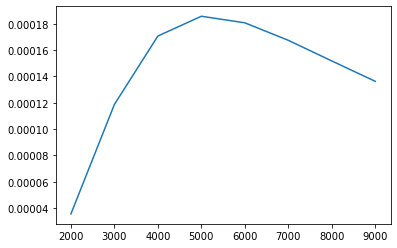

In [21]:
plt.plot(tracing_wavelength,bb[0])

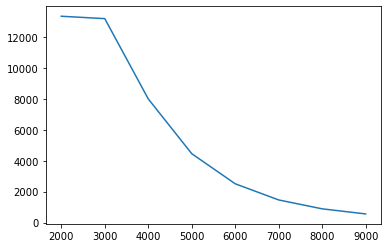

In [22]:
plt.plot(tracing_wavelength,bb[0]*tracing_nus/tracing_wavelength**2)

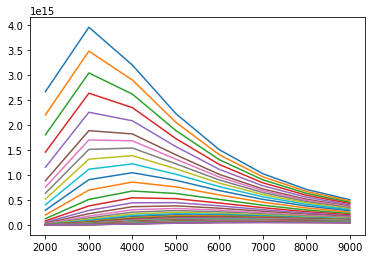

In [23]:
for i in range(55):
    plt.plot(tracing_wavelength,bbw[i])

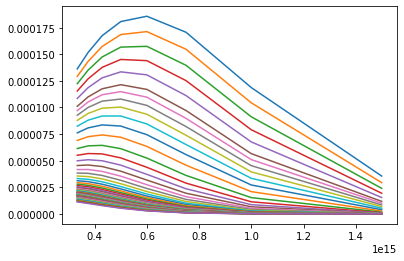

In [24]:
for i in range(55):
    plt.plot(tracing_nus,bb[i])

In [25]:
marcs_model.t.values

array([9934.3, 9678.4, 9424.6, 9168.5, 8903.8, 8620.2, 8462.6, 8290.4,
       8097.7, 7876.9, 7618.2, 7314.8, 6983.3, 6694.8, 6451.9, 6235.2,
       6044.3, 5875.7, 5727.4, 5597.1, 5483.1, 5382.5, 5294.4, 5216.8,
       5148.5, 5088.6, 5034.4, 4988.1, 4944.1, 4905.9, 4870.5, 4838.3,
       4808.6, 4780.9, 4754.7, 4729.9, 4706. , 4682.9, 4660.2, 4637.8,
       4615.6, 4593.5, 4571.5, 4549.5, 4527.4, 4504.9, 4461. , 4416.3,
       4371.3, 4326.1, 4280.8, 4235.5, 4190.4, 4145.9, 4102.6, 4066.8])

In [26]:
bb

<Quantity [[3.55959357e-05, 1.18744992e-04, 1.70704286e-04,
            1.85733857e-04, 1.80738577e-04, 1.67458112e-04,
            1.51770684e-04, 1.36282703e-04],
           [2.93895734e-05, 1.04414367e-04, 1.54731613e-04,
            1.71302143e-04, 1.68539864e-04, 1.57332509e-04,
            1.43366432e-04, 1.29259284e-04],
           [2.40555887e-05, 9.12896754e-05, 1.39663839e-04,
            1.57468318e-04, 1.56734547e-04, 1.47473632e-04,
            1.35149929e-04, 1.22372919e-04],
           [1.94347400e-05, 7.91286133e-05, 1.25256022e-04,
            1.44012105e-04, 1.45133479e-04, 1.37721727e-04,
            1.26986592e-04, 1.15509782e-04],
           [1.53900138e-05, 6.76801148e-05, 1.11219978e-04,
            1.30655519e-04, 1.33488373e-04, 1.27862064e-04,
            1.18692751e-04, 1.08512922e-04],
           [1.17968551e-05, 5.66468691e-05, 9.71616377e-05,
            1.16991452e-04, 1.21422338e-04, 1.17561835e-04,
            1.09979980e-04, 1.01133693e-04],
          

In [27]:
source = bb[1:].value
delta_source = bb.diff(axis=0).value  # for cells, not boundary

### RT Equation

In [69]:
# I_nu (specific intensity) is calculated at each cell boundary, shape: (56,800000)
I_nu = np.ones((delta_tau_lines.shape[1] + 1, len(tracing_nus))) * -99
I_nu[0] = np.zeros(len(tracing_nus))#bb[30]  # the innermost boundary is photosphere
num_of_shells = len(I_nu) - 1

for i in range(len(tracing_nus)):  # iterating over nus (columns)
    nu, line_id_start, line_id_end = (
        tracing_nus[i],
        line_id_starts[i],
        line_id_ends[i],
    )

    if line_id_start != line_id_end:
        delta_tau = delta_tau_lines[line_id_start:line_id_end]
        delta_nu = nu.value - lines_nu[line_id_start:line_id_end]
        tau_nus = calc_tau_nus(delta_tau, delta_nu)
        print(tau_nus)

    else:
        tau_nus = np.zeros(I_nu.shape[0] - 1)

    for j in range(num_of_shells):  # iterating over cells/shells (rows)
        cur_tau_h_minus = 0.0
        cur_tau_h_minus = tau_h_minus[j,i] # FIXME: making the lines in spectrum to extend to -ve Y axis, why? order difference?
        w0, w1 = calc_weights(tau_nus[j] + cur_tau_h_minus)
        print(w0)

        if tau_nus[j] == 0:
            second_term = 0
        else:
            second_term = w1 * delta_source[j, i] / tau_nus[j]

        I_nu[j + 1, i] = (1 - w0) * I_nu[j, i] + w0 * source[j, i] + second_term



0.9938474624054693
0.9706410502747237
0.9132415618423724
0.8180656440358623
0.6960432080426944
0.3612357673972817
0.313284482160461
0.2717955393893188
0.23540802297980412
0.20330851197984667
0.17516592646685758
0.14917040456149822
0.1227361630998185
0.098200069555884
0.07677916287338027
0.05863952980503728
0.043679219866070484
0.031799669680453
0.02269154118973271
0.015960582615438645
0.011166377118605464
0.007812306203923258
0.005486115605049968
0.003913414616942945
0.002814104946849305
0.0020326092879549007
0.00150588689025144
0.0011181645086553171
0.0008306041508528983
0.0006307932242195502
0.0004784954030701514
0.000365032685243887
0.0002816775974990233
0.00021656748692702106
0.00016696133700011567
0.0001299067122821664
0.00010050227747609633
7.836949240429199e-05
6.068178418062328e-05
4.697722843193321e-05
3.661738996763821e-05
2.8320838881173568e-05
2.2048934083064497e-05
1.714944560158729e-05
1.3122415070571535e-05
1.8556070649980027e-05
1.1058197641707103e-05
6.553632683937153e

### Plotting

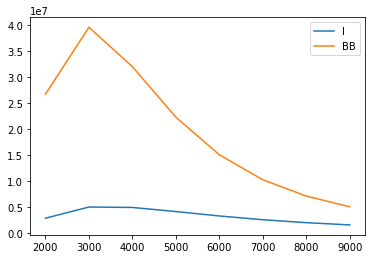

In [57]:
I_lambda = (I_nu[55])*tracing_nus/tracing_wavelength

cur_bb = bb[0]*tracing_nus/tracing_wavelength #TODO: check why 0, shouldn't it be 55 like I_nu?

plt.plot(tracing_wavelength, I_lambda, label="I")
plt.plot(tracing_wavelength, cur_bb, label="BB")
# plt.xlim(4330,4350) # to see 1st feature
# plt.xlim(6500, 6600) # to see last feature
#plt.xlim(2000,10000) 
plt.legend()

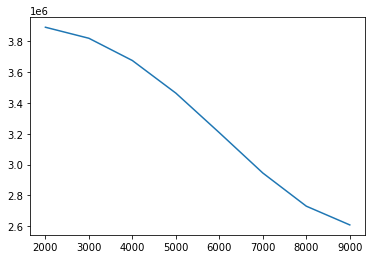

In [58]:
plt.plot(tracing_lambda, ndimage.gaussian_filter1d(I_lambda,3))

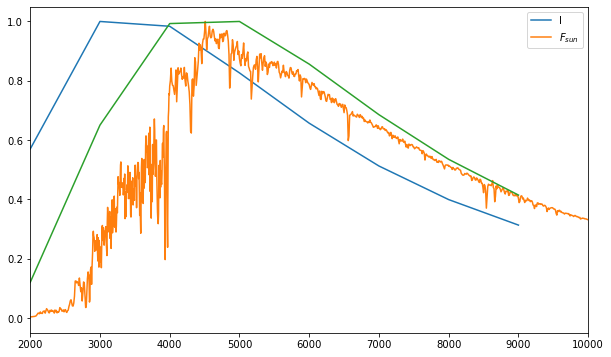

In [68]:
plt.figure(figsize=(10,6))
plt.plot(tracing_wavelength, I_lambda/I_lambda.max(), label="I")
plt.plot(sun_spec.wave, sun_spec.flux/sun_spec.flux.max(), label="$F_{sun}$")
plt.plot(tracing_wavelength,bbw[14]/bbw[14].max())

plt.xlim((2000,10000))
plt.legend()

In [ ]:
(const.b_wien/(9000 * u.K)).to(u.angstrom)

In [ ]:
I_nu.shape